<a href="https://colab.research.google.com/github/panstenos/IMDB-Review-Sentiment-NLP-PyTorch/blob/main/NLP_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Collection

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
import os
folder_dir = '/content/drive/MyDrive/Colab Notebooks/Getting started with PyTorch'
%cd folder_dir
!unzip archive.zip

[Errno 2] No such file or directory: 'folder_dir'
/content
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [204]:
import pandas as pd

file_path = os.path.join(folder_dir, 'IMDB Dataset.csv')
df = pd.read_csv(file_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Check for duplicates

In [205]:
df.duplicated().value_counts()

False    49582
True       418
Name: count, dtype: int64

In [206]:
df = df.drop_duplicates()
df.duplicated().value_counts()

False    49582
Name: count, dtype: int64

In [207]:
df.sentiment.value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [208]:
df['sentiment'] = df['sentiment'].replace({'positive':1, 'negative':0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# 2. Tokenization and data Pipeline

In [209]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# tokenizer
tokenizer = get_tokenizer('basic_english')

# vocabulary
texts, labels = list(df.review.values), list(df.sentiment.values)
def yield_tokens(texts):
  for text in texts:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(texts), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>']) # default for oov

In [210]:
from torch.nn.utils.rnn import pad_sequence
import torch

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
encoded_texts = [torch.tensor(text_pipeline(sentence)) for sentence in texts]

encoded_texts_pad = pad_sequence(encoded_texts, batch_first=True, padding_value=vocab['<pad>'])

In [211]:
from torch.utils.data import DataLoader, TensorDataset, random_split

labels_tensor = torch.tensor(labels)

dataset = TensorDataset(encoded_texts_pad, labels_tensor)
test_size = int(0.20 * len(dataset))
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

batch_size = 50
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# 4. Modelling

In [212]:
class LSTMClassifier(torch.nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMClassifier, self).__init__()
    self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
    self.lstm = torch.nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
    self.fc1 = torch.nn.Linear(2*hidden_dim, output_dim)

  def forward(self, text):
    x = self.embedding(text)
    lstm_out, (h, c) = self.lstm(x)
    h = torch.cat((h[-2], h[-1]), dim=1)
    x = self.fc1(h)
    return x

In [213]:
torch.cuda.empty_cache()
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=32, hidden_dim=32, output_dim=1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model

LSTMClassifier(
  (embedding): Embedding(147158, 32)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [214]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [215]:
from tqdm.auto import tqdm
import time

In [216]:
def train(model, train_loader, optimizer, criterion):
    correct = 0
    epoch_loss = 0
    total_samples = 0
    model.train()
    pbar = tqdm(train_loader, total=len(train_loader))

    for i, (x, y) in enumerate(pbar):  # Use the pbar directly here
        text, label = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(text).squeeze()
        loss = loss_fn(outputs, label.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        y_pred = (outputs > 0).type(torch.long)
        correct += (y_pred == label).sum().item()
        total_samples += label.size(0)
        accuracy = correct / total_samples

        pbar.set_postfix(ordered_dict={
          'batch': f"{int(i + 1)}/{len(train_loader)}",
          'train_accuracy': f"{accuracy * 100:.2f}%",
          'train_loss': f"{epoch_loss*train_loader.batch_size/total_samples:.4f}"
        }, refresh=True)
    pbar.close()
    return epoch_loss / len(train_loader), accuracy

In [217]:
def evaluate(model, test_loader, criterion):
    correct = 0
    epoch_loss = 0
    total_samples = 0
    model.eval()
    pbar = tqdm(test_loader, total=len(test_loader))

    with torch.no_grad():
        for i, (x, y) in enumerate(pbar):
            text, label = x.to(device), y.to(device)
            outputs = model(text).squeeze()
            loss = criterion(outputs, label.float())
            epoch_loss += loss.item()
            y_pred = (outputs > 0).type(torch.long)
            correct += (y_pred == label).sum().item()
            total_samples += label.size(0)
            accuracy = correct / total_samples

            pbar.set_postfix(ordered_dict={
              'batch': f"{int(i + 1)}/{len(test_loader)}",
              'valid_accuracy': f"{accuracy * 100:.2f}%",
              'valid_loss': f"{epoch_loss*test_loader.batch_size/total_samples:.4f}"
            }, refresh=True)
    pbar.close()
    return epoch_loss / len(test_loader), accuracy

In [218]:
num_epochs = 25
history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_acc = evaluate(model, test_loader, loss_fn)

    history.append([train_loss, valid_loss, train_acc, valid_acc])

    if train_acc > 0.99:
      print('\n More than 99.0% accuracy reached --> terminating training')
      break

Epoch 1/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 8/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 9/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 10/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 11/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 12/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]


 More than 99.0% accuracy reached --> terminating training


In [219]:
# Save the model state
torch.save(model.state_dict(), 'model_state.pth')

In [294]:
# Load the model
torch.cuda.empty_cache()
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=32, hidden_dim=32, output_dim=1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('model.pth'))
model.to(device)

LSTMClassifier(
  (embedding): Embedding(147158, 32)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [220]:
history_df = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
history_df.to_csv('model_history.csv', index=False)
history_df

,train_loss,valid_loss,train_acc,valid_acc
0,0.691777,0.690416,0.522790,0.549718
1,0.642273,0.550544,0.623153,0.754336
2,0.398377,0.346612,0.831619,0.856091
3,0.270006,0.296151,0.895149,0.880294
4,0.210696,0.302646,0.923511,0.881101
5,0.167204,0.298487,0.942949,0.888866
6,0.134473,0.301414,0.956588,0.889875
7,0.104184,0.354822,0.970075,0.885034
8,0.081516,0.360978,0.978344,0.886749
9,0.064628,0.384690,0.983890,0.884631


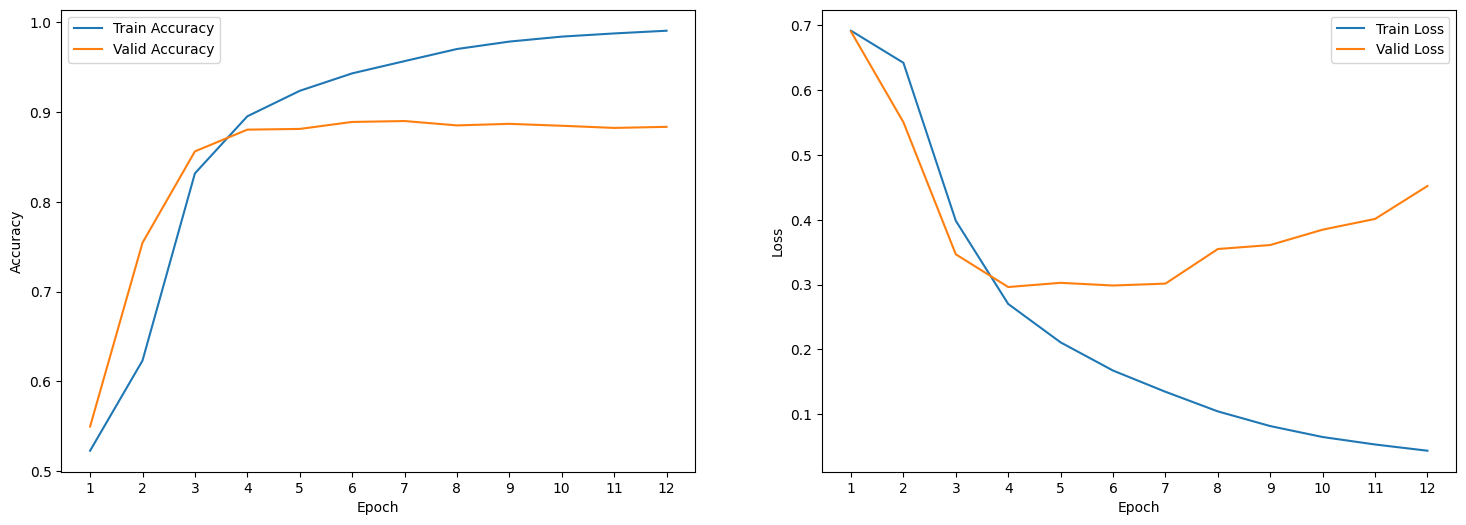

In [252]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['train_acc'], label='Train Accuracy')
ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_acc'], label='Valid Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax1.legend()

ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['train_loss'], label='Train Loss')
ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_loss'], label='Valid Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax2.legend()

fig.show()

# 5. Classify Custom Review

In [295]:
def process_input_from_keyboard():
    input_sentence = input("Please enter a sentence: ")

    encoded_sentence = torch.tensor(text_pipeline(input_sentence))
    padded_encoded_sentence = pad_sequence([encoded_sentence], batch_first=True, padding_value=vocab['<pad>'])

    with torch.no_grad():  # Disable gradient computation
        output = model(padded_encoded_sentence.to(device))
        y_pred = (output > 0).type(torch.long)
        confidence = torch.sigmoid(torch.abs(output)).item()*100

    predicted_label = label_mapping(y_pred)
    print(f"This review is {predicted_label}. ({confidence:.2f}% confidence)")
def label_mapping(index):
    return "Positive" if index == 1 else "Negative"

process_input_from_keyboard()

Please enter a sentence: "I recently watched 'Eternal Shadows' and was profoundly disappointed. The plot was disjointed and difficult to follow, littered with underdeveloped characters and erratic pacing. The special effects, which could have saved the film, were subpar and unconvincing. Even the performances, despite a star-studded cast, felt forced and lacked depth. Overall, 'Eternal Shadows' failed to deliver on its promising premise, making it a tedious watch."
This review is Negative. (99.91% confidence)
